In [1]:
import os
import pandas as pd
import glob
from pyproj import Geod
from pyproj import Proj
from pykalman import KalmanFilter
import numpy as np

In [2]:
#convert_wgs_to_utm function, see https://stackoverflow.com/questions/40132542/get-a-cartesian-projection-accurate-around-a-lat-lng-pair

def convert_wgs_to_utm(lon, lat):
    utm_band = str((np.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

def process_postion(item):
    

    try:
        lat = float(item['data']['values']['latitude'])
        lon = float(item['data']['values']['longitude'])
    except:
        lon = pd.np.nan
        lat = pd.np.nan

    return {'timestamp':item.name,'latitude':lat,'longitude':lon}

def process_pressure(item):
    return {'timestamp':item.name,"pressure":float(item['data']['values']['pressure'])}
    
def process_usbl(item):
    return {'timestamp':item.name,"X":item['data']['values']['usbl_athwart'],
           "Y":item['data']['values']['usbl_fore_aft'],
           "Depth":item['data']['values']['usbl_depth']}

    
def process_alt(item):
    
    try:
        alt = float(item['data']['values']['altitude'])
    except:
        alt=pd.np.nan
    if alt==99.99:
        alt=pd.np.nan

    return {'timestamp':item.name,"Altitude":alt}


def process_heading(item):
    try:
        heading = float(item['data']['values']['heading'])
    except:
        heading=pd.np.nan
    return {'timestamp':item.name,"ShipHeading":heading} 

def removespikes(data,threshold,window=5):
    difference = np.abs(data -data.rolling(window=5, center=True).median())
    outlier_idx = difference > threshold
    data[outlier_idx]=np.nan
    return data

def get_median_filtered(signal, threshold=3):
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

In [3]:
files = glob.glob('s:/HSV/Log Files/clean/*.json')

In [83]:
def process_file(file):
    log =pd.read_json(file,lines=True).set_index('timestamp')
    sonardyne ='.*X:(?P<X>[0-9-]*\.[0-9]*).*Y:(?P<Y>[0-9-]*\.[0-9]*).*D:(?P<D>[0-9-]*\.[0-9]*).*H:(?P<H>[0-9-]*\.[0-9]*)'
    sondardyne_raw=log[log.message=="linnaeus.sonardyne_scout.usbl.raw"]['data'].str.extract(sonardyne)[['X','Y','D','H']].astype(float).dropna()

    hsv_position  = pd.DataFrame.from_records(log[(log.message=="hsv.application.position.eng") | ( log.message=="hsv.sonardyne_scout.calculated_beacon_position.eng")].apply(process_postion,axis=1)).set_index('timestamp')
    hsv_pressure  = pd.DataFrame.from_records(log[log.message=="hsv.pressure.telemetry.eng"].apply(process_pressure,axis=1)).set_index('timestamp')
    ship_position = pd.DataFrame.from_records(log[log.message=="linnaeus.furuno.gps.eng"].apply(process_postion,axis=1)).set_index('timestamp')
    hsv_altitude  = pd.DataFrame.from_records(log[log.message=="hsv.benthos.altimeter.eng"].apply(process_alt,axis=1)).set_index('timestamp')
    hsv_altitude = hsv_altitude[hsv_altitude.Altitude<20]
    ship_heading  = pd.DataFrame.from_records(log[log.message=="linnaeus.furuno.heading.eng"].apply(process_heading,axis=1)).set_index('timestamp')
    usbl_position  = pd.DataFrame.from_records(log[log.message=="linnaeus.sonardyne_scout.usbl.eng"].apply(process_usbl,axis=1)).set_index('timestamp')
    usbl_position.Depth =usbl_position.Depth.str.extract('.*:(?P<value>.*)')['value'].astype(float)
    usbl_position.X =usbl_position.X.str.extract('.*:(?P<value>.*)')['value'].astype(float)
    usbl_position.Y =usbl_position.Y.str.extract('.*:(?P<value>.*)')['value'].astype(float)
    usbl_position.index =usbl_position.index.round('100L')
    usbl_position.dropna(inplace=True)

    hsv_altitude.index =hsv_altitude.index.round('100L')

    hsv_position.columns = ['HSVLatitude','HSVLongitude']
    hsv_position.index =hsv_position.index.round('100L')
    hsv_position.columns = ['HSVLatitude','HSVLongitude']
    hsv_position.index =hsv_position.index.round('100L')
    hsv_pressure.columns = ['HSVPressure']
    hsv_pressure.index =hsv_pressure.index.round('100L')
    hsv_altitude.columns = ['HSVAltitude']
    hsv_altitude.index =hsv_altitude.index.round('100L')
    ship_position.columns = ['ShipLatitude','ShipLongitude']
    ship_position.index =ship_position.index.round('100L')
    utmcode =convert_wgs_to_utm(ship_position.ShipLongitude[0],ship_position.ShipLatitude[0])
    utmproj =Proj(init='epsg:{0:1.5}'.format(utmcode))
    ship_position.dropna(inplace=True)
    e,n =utmproj(ship_position.ShipLongitude.values,ship_position.ShipLatitude.values)
    ship_position['ShipEasting']=e
    ship_position['ShipNorthing']=n
    hsv_position.dropna(inplace=True)
    e,n =utmproj(hsv_position.HSVLongitude.values,hsv_position.HSVLatitude.values)
    hsv_position
    hsv_position['HSVEasting']=e
    hsv_position['HSVNorthing']=n

    ship_heading['u'] = np.cos(np.deg2rad(ship_heading.ShipHeading)).rolling(7,min_periods=1,center=True).mean()
    ship_heading['v'] = np.sin(np.deg2rad(ship_heading.ShipHeading)).rolling(7,min_periods=1,center=True).mean()
    ship_heading['ShipHeadingSmoothed'] =np.rad2deg(np.arctan2(ship_heading['v'],ship_heading['u']))

    #ship_heading.loc[ ship_heading.ShipHeadingSmoothed<-180,'ShipHeadingSmoothed'] = 360+ship_heading.loc[ ship_heading.ShipHeadingSmoothed<-180,'ShipHeadingSmoothed']
    ship_heading.loc[ ship_heading.ShipHeadingSmoothed<0,'ShipHeadingSmoothed'] = 360+ship_heading.loc[ ship_heading.ShipHeadingSmoothed<0,'ShipHeadingSmoothed']
    position_data = pd.concat([sondardyne_raw,ship_position,ship_heading,hsv_position,hsv_altitude,hsv_pressure],sort=False).sort_index()

    position_data =position_data[['ShipLatitude','ShipLongitude','ShipEasting','ShipNorthing','ShipHeading','HSVEasting','HSVNorthing','ShipHeadingSmoothed','HSVAltitude','HSVPressure']].interpolate().dropna()
    sondardyne_raw =sondardyne_raw.join(position_data).dropna()
    cangle = np.exp((2*np.pi*(sondardyne_raw.ShipHeadingSmoothed)/360)*1j)
    x =cangle * (sondardyne_raw.Y.values+sondardyne_raw.X.values * 1j)
    sondardyne_raw['XPrime']=x.real
    sondardyne_raw['YPrime']=x.imag
    sondardyne_raw.XPrime = removespikes(sondardyne_raw.XPrime,20).interpolate().rolling(7,min_periods=1,center=True).mean()
    sondardyne_raw.YPrime = removespikes(sondardyne_raw.YPrime,20).interpolate().rolling(7,min_periods=1,center=True).mean()
    sondardyne_raw['UsblNorthing'] =sondardyne_raw['ShipNorthing']+sondardyne_raw['XPrime']
    sondardyne_raw['UsblEasting'] =sondardyne_raw['ShipEasting']+sondardyne_raw['YPrime']
    sondardyne_raw['HSVDistance']=np.power(np.power(sondardyne_raw.HSVEasting - sondardyne_raw.ShipEasting,2) + np.power(sondardyne_raw.HSVNorthing - sondardyne_raw.ShipNorthing,2),0.5)
    sondardyne_raw['RawDistance']=np.power(np.power(sondardyne_raw.X,2) + np.power(sondardyne_raw.Y,2),0.5)
    sondardyne_raw['UsblDistance']=np.power(np.power(sondardyne_raw.UsblEasting - sondardyne_raw.ShipEasting,2) + np.power(sondardyne_raw.UsblNorthing - sondardyne_raw.ShipNorthing,2),0.5)
    sondardyne_raw['UtmCode'] = 'epsg:{0:1.5}'.format(utmcode)
    return sondardyne_raw

In [65]:
files[1]

's:/HSV/Log Files/clean\\HSV_LI2019_V05_002_2019_03_28_06_18_46.json'

In [66]:
result,heading =process_file(files[1])

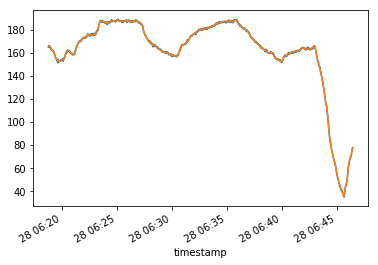

In [67]:
%matplotlib inline
heading.ShipHeading.plot()
(heading.ShipHeadingSmoothed).plot()

In [87]:
for file in files:
    print(file)
    result =process_file(file)
    result.to_csv(file.replace('.json','.csv'),index=True)

s:/HSV/Log Files/clean\HSV_LI2019_V05_001_2019_03_28_04_51_36.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_002_2019_03_28_06_18_46.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_003_2019_03_28_06_58_22.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_004_2019_03_29_00_28_13.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_005_2019_03_29_01_03_01.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_006_2019_03_29_01_56_54.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_007_2019_03_29_02_41_18.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_008_2019_03_29_03_20_02.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_009_2019_03_29_04_20_53.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_010_2019_03_29_23_33_46.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_011_2019_03_30_00_16_48.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_012_2019_03_30_01_07_24.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_013_2019_03_30_01_50_07.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_014_2019_03_30_02_28_45.json
s:/HSV/Log Files/clean\HSV_LI2019_V05_015_2019_03_30_03_10_54.

In [88]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [92]:
result.UtmCode[0][5:]

'32749'

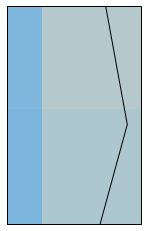

In [113]:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([742752,795930,7403680,7499473], crs=ccrs.epsg(result.UtmCode[0][5:]))
    ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')



    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')

C:\ProgramData\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
C:\ProgramData\Anaconda3\lib\site-packages\cartopy\io\__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


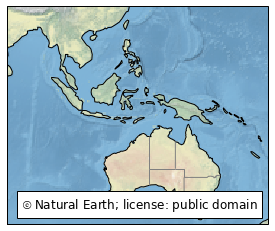

In [89]:
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([80, 170, -45, 30], crs=ccrs.epsg(result.UtmCode[0][5:])

    # Put a background image on for nice sea rendering.
    ax.stock_img()

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')

    # Add a text annotation for the license information to the
    # the bottom right corner.
    ax.add_artist(text)

    plt.show()

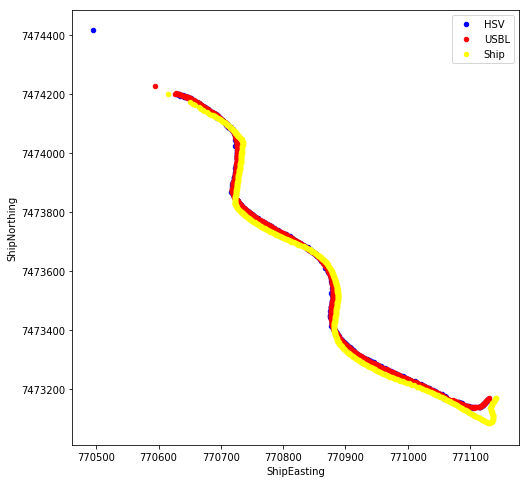

In [75]:
fig, ax = plt.subplots(figsize=(8,8))

result.plot.scatter(ax=ax,x='HSVEasting',y='HSVNorthing',color='blue',label='HSV')
result.plot.scatter(ax=ax,x='UsblEasting',y='UsblNorthing',color='Red',label='USBL')
result.plot.scatter(ax=ax,x='ShipEasting',y='ShipNorthing',color='yellow',label='Ship')

In [85]:
result =process_file(files[0])

In [86]:
result

,X,Y,D,H,ShipLatitude,ShipLongitude,ShipEasting,ShipNorthing,ShipHeading,HSVEasting,...,HSVAltitude,HSVPressure,XPrime,YPrime,UsblNorthing,UsblEasting,HSVDistance,RawDistance,UsblDistance,UtmCode
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-03-28 04:54:12.758,17.7,-38.1,57.7,334.3,-22.709216,113.510921,757929.209334,7.486487e+06,337.308333,757959.191058,...,14.100000,59.280000,-29.616734,30.603027,7.486457e+06,757959.812362,41.843375,42.010713,42.587512,epsg:32749
2019-03-28 04:54:14.729,18.4,-38.9,57.7,338.0,-22.709207,113.510908,757927.917376,7.486488e+06,339.160000,757958.586320,...,14.166240,60.386000,-29.617212,30.687734,7.486458e+06,757958.605110,42.562620,43.032197,42.648755,epsg:32749
2019-03-28 04:54:16.808,16.7,-38.6,59.0,336.5,-22.709201,113.510894,757926.458086,7.486488e+06,339.770000,757956.869123,...,14.254559,60.810000,-29.967145,30.751952,7.486458e+06,757957.210038,42.983049,42.057698,42.938472,epsg:32749
2019-03-28 04:54:18.779,18.1,-39.3,58.8,336.6,-22.709193,113.510875,757924.532058,7.486489e+06,337.620000,757954.600199,...,14.334047,60.913333,-30.255066,30.899773,7.486459e+06,757955.431831,42.321699,43.267771,43.245404,epsg:32749
2019-03-28 04:54:20.747,18.5,-38.7,60.9,337.4,-22.709178,113.510865,757923.614332,7.486491e+06,339.200000,757955.197314,...,14.417950,62.250000,-30.631924,31.065216,7.486460e+06,757954.679549,43.261678,42.894522,43.627542,epsg:32749
2019-03-28 04:54:22.829,18.2,-40.5,60.4,337.9,-22.709171,113.510849,757921.942415,7.486492e+06,340.500000,757952.714909,...,14.510686,63.358571,-31.079744,31.224542,7.486461e+06,757953.166956,43.886945,44.401464,44.055902,epsg:32749
2019-03-28 04:54:24.801,19.2,-40.8,62.2,338.4,-22.709163,113.510836,757920.610386,7.486493e+06,339.990000,757951.979333,...,14.590173,64.860000,-31.610857,31.655138,7.486461e+06,757952.265524,44.873467,45.091906,44.735825,epsg:32749
2019-03-28 04:54:26.770,19.7,-40.1,64.6,337.8,-22.709152,113.510823,757919.347145,7.486494e+06,340.160000,757951.558381,...,14.669661,66.446667,-32.162850,32.124055,7.486462e+06,757951.471200,45.351353,44.677735,45.457715,epsg:32749
2019-03-28 04:54:28.850,20.5,-41.2,65.5,339.3,-22.709140,113.510806,757917.559779,7.486495e+06,342.560000,757949.563757,...,14.762396,68.490000,-32.862277,32.305858,7.486462e+06,757949.865636,45.705442,46.018366,46.082510,epsg:32749
